### Authors

* **Deepak Hazarika** 
* **Parinita Bora**
* **Gurudatta**


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import logging
import sys
from datetime import datetime

now = datetime.now()

#sys.stdout = open('logfile' + str(now) + '.log','a')

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='logfile.log',
                    filemode='a')

logging.info("Start " + str(now))
print("Start of logging " + str(now))

Start of logging 2020-08-22 06:55:30.708030


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


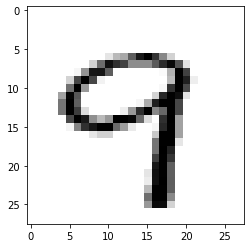

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

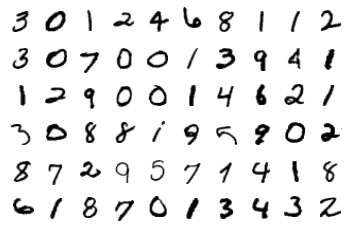

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(11),
            nn.ReLU()
        ) # output_size = 7
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 5

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 3

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(13),
            nn.ReLU()
        ) # output_size = 1


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.item(), correct, processed ,
        100. * correct / processed))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.04246298223733902 Batch_id=937 Accuracy=92.41: 100%|██████████| 938/938 [01:37<00:00,  9.66it/s]



Train set: Average loss: 0.0425, Accuracy: 55447/60000 (92.41%)



Loss=0.11083698272705078 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:37,  9.60it/s]


Test set: Average loss: 0.0543, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.11982286721467972 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [01:36<00:00,  9.68it/s]



Train set: Average loss: 0.1198, Accuracy: 58759/60000 (97.93%)



Loss=0.04279650002717972 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:39,  9.37it/s]


Test set: Average loss: 0.0369, Accuracy: 9880/10000 (98.80%)

EPOCH: 2


Loss=0.10463887453079224 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [01:35<00:00,  9.78it/s]



Train set: Average loss: 0.1046, Accuracy: 59040/60000 (98.40%)



Loss=0.1395168900489807 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:30, 10.35it/s]


Test set: Average loss: 0.0352, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.31928226351737976 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [01:33<00:00, 10.06it/s]



Train set: Average loss: 0.3193, Accuracy: 59150/60000 (98.58%)



Loss=0.020495370030403137 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.80it/s]


Test set: Average loss: 0.0344, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.015713445842266083 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:32<00:00, 10.17it/s]



Train set: Average loss: 0.0157, Accuracy: 59296/60000 (98.83%)



Loss=0.05036654323339462 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:29, 10.48it/s]


Test set: Average loss: 0.0310, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.17620410025119781 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [01:31<00:00, 10.28it/s]



Train set: Average loss: 0.1762, Accuracy: 59340/60000 (98.90%)



Loss=0.012824374251067638 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:39,  9.40it/s]


Test set: Average loss: 0.0317, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.01818999834358692 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:30<00:00, 10.39it/s]



Train set: Average loss: 0.0182, Accuracy: 59442/60000 (99.07%)



Loss=0.0015206207754090428 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.56it/s]


Test set: Average loss: 0.0308, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.005657062865793705 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [01:30<00:00, 10.36it/s]



Train set: Average loss: 0.0057, Accuracy: 59433/60000 (99.06%)



Loss=0.007192648947238922 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:31, 10.27it/s]


Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.01726527325809002 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:30<00:00, 10.40it/s]



Train set: Average loss: 0.0173, Accuracy: 59498/60000 (99.16%)



Loss=0.007605995051562786 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:27, 10.71it/s]


Test set: Average loss: 0.0293, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.004035416524857283 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:30<00:00, 10.36it/s]



Train set: Average loss: 0.0040, Accuracy: 59515/60000 (99.19%)



Loss=0.01946030929684639 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.60it/s]


Test set: Average loss: 0.0338, Accuracy: 9900/10000 (99.00%)

EPOCH: 10


Loss=0.005384280811995268 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [01:30<00:00, 10.37it/s]



Train set: Average loss: 0.0054, Accuracy: 59573/60000 (99.29%)



Loss=0.010957086458802223 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.84it/s]


Test set: Average loss: 0.0292, Accuracy: 9903/10000 (99.03%)

EPOCH: 11


Loss=0.01232957560569048 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:30<00:00, 10.34it/s]



Train set: Average loss: 0.0123, Accuracy: 59585/60000 (99.31%)



Loss=0.01427309401333332 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:27, 10.67it/s]


Test set: Average loss: 0.0291, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.20931124687194824 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:32<00:00, 10.17it/s]



Train set: Average loss: 0.2093, Accuracy: 59580/60000 (99.30%)



Loss=0.0172417014837265 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:26, 10.81it/s]


Test set: Average loss: 0.0260, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.010685618035495281 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:30<00:00, 10.35it/s]



Train set: Average loss: 0.0107, Accuracy: 59617/60000 (99.36%)



Loss=0.008103480562567711 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:34,  9.92it/s]


Test set: Average loss: 0.0334, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.03833446651697159 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [01:30<00:00, 10.37it/s]



Train set: Average loss: 0.0383, Accuracy: 59657/60000 (99.43%)


Test set: Average loss: 0.0282, Accuracy: 9921/10000 (99.21%)



Text(0.5, 1.0, 'Test Accuracy')

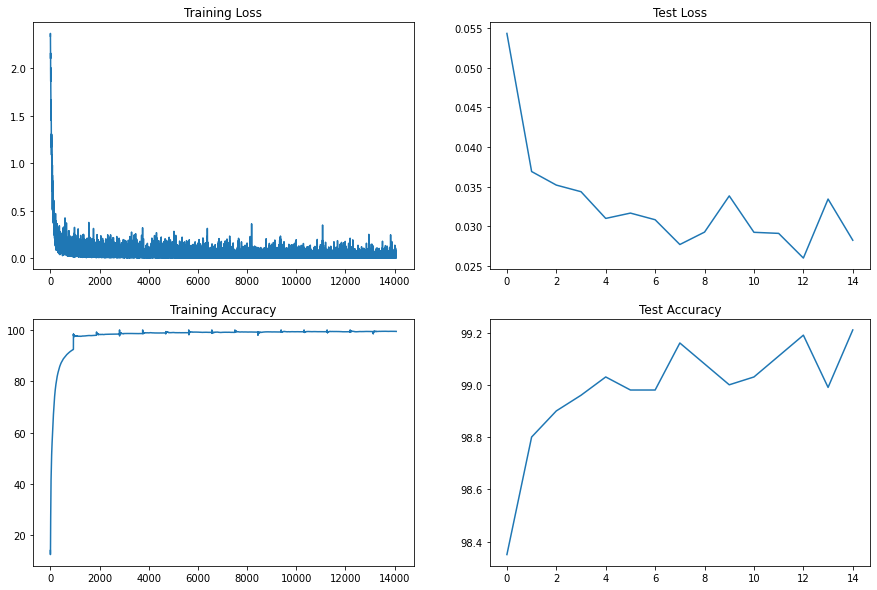

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
print("End of logging V1" + str(now))

End of logging V12020-08-22 06:55:30.708030
